In [2]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
import plotly.graph_objects as go
import plotly.io as pio
from tabulate import tabulate
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import seaborn as sns


from cordex_discrete import cordex_discrete
from cordex_continuous import cordex_continuous
from plot_fun import subplot_results
from Jcb import calc_basis_matrix, Jcb

from autoencoder import create_train_val_set, create_autoencoder, create_autoencoder_enhanced, fit_autoencoder, fit_denoising_autoencoder, plot_history, fit_vae, create_vae, fit_autoencoder_custom

from latent_bo import objective_function, latent_auto_bo, latent_manual_bo, plot_convergence, plot_obj, plot_evals

In [3]:
def create_train_val_set_random(runs, n_x, scalars, optimality, J_cb,
                                num_designs=1000, test_size=0.2, random_state=42, noise=None, max_iterations=100000, epsilon=1e-10):

    design_matrices = []
    valid_count = 0
    for _ in tqdm(range(max_iterations)):
        if valid_count >= num_designs:
            break

        candidate_matrix = np.random.uniform(-1, 1, size=(runs, n_x[0]))

        Z = np.hstack([np.ones((runs, 1)), candidate_matrix @ J_cb])
        ZTZ = Z.T @ Z
        determinant = np.linalg.det(ZTZ)

        if determinant > epsilon:
            design_matrices.append(candidate_matrix)
            valid_count += 1

    if valid_count < num_designs:
        print(f"Warning: Only {valid_count} valid design matrices found after {max_iterations} iterations")

    design_matrices = np.stack(design_matrices)

    scaler = MinMaxScaler(feature_range=(-1, 1))
    normalized_designs = scaler.fit_transform(design_matrices.reshape(num_designs, -1))

    if noise is not None:
        noisy_designs = normalized_designs + noise * np.random.normal(size=normalized_designs.shape)
        noisy_designs = np.clip(noisy_designs, -1, 1)

        x_train, x_val, y_train, y_val = train_test_split(noisy_designs, normalized_designs, test_size=test_size,
                                                          random_state=random_state)
        return x_train, x_val, y_train, y_val
    else:
        train_data, val_data = train_test_split(normalized_designs, test_size=test_size, random_state=random_state)
        return train_data, val_data

In [4]:
def select_top_n_designs(des_train, des_val, objective_function, m, n, J_cb, noise=0, upscale=10):
    # Calculate the number of top designs based on the proportion of des_train and des_val
    top_n_train = int(des_train.shape[0] / 10)
    top_n_val = int(des_val.shape[0] / 10)

    # Evaluate the objective function for each design
    train_objective_values = [objective_function(d, m, n, J_cb=J_cb, noise=noise) for d in des_train]
    val_objective_values = [objective_function(d, m, n, J_cb=J_cb, noise=noise) for d in des_val]

    # Combine the designs and their objective function values
    train_designs_with_values = list(zip(train_objective_values, des_train))
    val_designs_with_values = list(zip(val_objective_values, des_val))

    # Sort the designs based on their objective function values (ascending order)
    sorted_train_designs_with_values = sorted(train_designs_with_values, key=lambda x: x[0])
    sorted_val_designs_with_values = sorted(val_designs_with_values, key=lambda x: x[0])

    # Select the top num_top_designs designs
    des_train_top_n = [design for _, design in sorted_train_designs_with_values[:top_n_train]]
    des_val_top_n = [design for _, design in sorted_val_designs_with_values[:top_n_val]]

    # Replicate the top designs 10 times to get back to the original dimensions
    des_train_top_n_scaled = np.repeat(des_train_top_n, upscale, axis=0)
    des_val_top_n_scaled = np.repeat(des_val_top_n, upscale, axis=0)

    # Randomize the order of the designs
    np.random.shuffle(des_train_top_n_scaled)
    np.random.shuffle(des_val_top_n_scaled)

    return np.array(des_train_top_n_scaled), np.array(des_val_top_n_scaled)

In [114]:
def optimize_designs(encoder, decoder, encoder_noisy, decoder_noisy, cordex_discrete, objective_function, runs, n_x, scalars, optimality, J_cb, n_repetitions=10, n_iterations=3, use_denoising=True, use_normal=True):
    results = []
    all_designs = []

    for rep in tqdm(range(n_repetitions)):
        cordex_mat, cordex_opt = cordex_discrete(runs=runs,
                                                 f_list=n_x,
                                                 scalars=scalars,
                                                 levels=[-1, 1],
                                                 epochs=5,
                                                 optimality=optimality,
                                                 J_cb=J_cb,
                                                 disable_bar=True)

        objective_function_values = [cordex_opt]
        designs = [cordex_mat]


        if use_denoising:
            for i in range(n_iterations):
                encoded_denoise = encoder_noisy.predict(np.reshape(cordex_mat, (1, -1)), verbose=0)
                decoded_denoise = decoder_noisy.predict(encoded_denoise, verbose=0).reshape(cordex_mat.shape)

                obj_val = objective_function(np.round(decoded_denoise), m=runs, n=sum(n_x), J_cb=J_cb, noise=0)
                objective_function_values.append(obj_val)

                designs.append(decoded_denoise)
                cordex_mat = decoded_denoise
        if use_normal:
            for j in range(n_iterations):
                encoded_result = encoder.predict(np.reshape(cordex_mat, (1, -1)), verbose=0)
                decoded_result = decoder.predict(encoded_result, verbose=0).reshape(cordex_mat.shape)

                obj_val = objective_function(np.round(decoded_result), m=runs, n=sum(n_x), J_cb=J_cb, noise=0)
                objective_function_values.append(obj_val)

                designs.append(decoded_result)
                cordex_mat = decoded_result

        results.append(objective_function_values)
        all_designs.append(designs)

    return results, all_designs

def plot_results(results, n_repetitions):
    fig, ax = plt.subplots()
    plt.style.use('default')
    colors = plt.cm.jet(np.linspace(0, 1, n_repetitions))
    title = use_denoising * "Denoising " + use_normal * "Normal " + "Autoencoder"
    for idx, (result, color) in enumerate(zip(results, colors)):
        ax.plot(result, '-o', label=f"Rep_{idx}", color=color, alpha=min(1/n_repetitions+0.3 , 1))

    ax.legend()
    plt.xlabel("Iteration")
    plt.ylabel("Objective Function Value")
    plt.title(f"Objective Function Values per Iteration and Repetition with \n{title}")
    # Set x-axis ticks to integer values
    num_iterations = len(results[0])
    ax.set_xticks(np.arange(0, num_iterations))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))
    plt.show()

def find_best_design(results, all_designs):
    results = np.array(results)
    min_row, min_col = np.unravel_index(np.argmin(results, axis=None), results.shape)
    best_obj_val = results[min_row, min_col]
    best_design = all_designs[min_row][min_col]

    return best_obj_val, best_design

## Settings

In [116]:
runs = 4
levels = np.linspace(-1,1,3).tolist()
optimality = 'A'
n_x = [100]
n_b = [2]
scalars = 0
J_cb = Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(n_x, n_b)])

In [69]:
# # Generate designs with different optimality criteria and settings
# design_settings = [
#     {'runs': 4, 'n_x': n_x, 'scalars': 0, 'optimality': 'A', 'J_cb': Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(n_x, n_b)]), 'num_designs': 1000},
#     {'runs': 4, 'n_x': n_x, 'scalars': 0, 'optimality': 'D', 'J_cb': Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(n_x, n_b)]), 'num_designs': 1000},
#     # Add more settings with different runs, n_x, and n_b values
# ]
#
# # Generate and concatenate datasets
# des_train_selected, des_val_selected = [], []
# max_size = 0
#
# for setting in design_settings:
#     n_x_sum = sum(setting['n_x'])
#     J_cb_current = Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(setting['n_x'], n_b)])
#
#     des_train, des_val = create_train_val_set(**setting, test_size=0.2, noise=None, cordex=cordex_discrete)
#     des_train_top_n, des_val_top_n = select_top_n_designs(des_train, des_val, objective_function, setting['runs'], n_x_sum, J_cb_current, noise=0, upscale=10)
#
#     max_size = max(max_size, des_train_top_n.shape[1], des_val_top_n.shape[1])
#
#     des_train_selected.append(des_train_top_n)
#     des_val_selected.append(des_val_top_n)
#
# # Pad arrays with zeros if necessary
# for i in range(len(des_train_selected)):
#     if des_train_selected[i].shape[1] < max_size:
#         padding = np.zeros((des_train_selected[i].shape[0], max_size - des_train_selected[i].shape[1]))
#         des_train_selected[i] = np.hstack((des_train_selected[i], padding))
#
#     if des_val_selected[i].shape[1] < max_size:
#         padding = np.zeros((des_val_selected[i].shape[0], max_size - des_val_selected[i].shape[1]))
#         des_val_selected[i] = np.hstack((des_val_selected[i], padding))
#
# des_train_selected = np.concatenate(des_train_selected, axis=0)
# des_val_selected = np.concatenate(des_val_selected, axis=0)
#
# # Randomize the order of the designs
# np.random.shuffle(des_train_selected)
# np.random.shuffle(des_val_selected)
#
# # Assign the concatenated top_n designs to des_train and des_val
# des_train, des_val = des_train_selected, des_val_selected

In [61]:
# design_settings = [
#     {'runs': 4, 'n_x': n_x, 'scalars': 0, 'optimality': 'A', 'J_cb': Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(n_x, n_b)]), 'num_designs': 3000},
#     {'runs': 4, 'n_x': n_x, 'scalars': 0, 'optimality': 'D', 'J_cb': Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(n_x, n_b)]), 'num_designs': 3000},
#     # Add more settings with different runs, n_x, and n_b values
# ]
#
# des_pure_train_selected, des_pure_val_selected, des_noisy_train_selected, des_noisy_val_selected = [], [], [], []
# max_size = 0
#
# for setting in design_settings:
#     des_pure_train, des_pure_val, des_noisy_train, des_noisy_val = create_train_val_set(**setting, test_size=0.2, noise=0.1, cordex=cordex_discrete)
#     max_size = max(max_size, des_pure_train.shape[1], des_pure_val.shape[1], des_noisy_train.shape[1], des_noisy_val.shape[1])
#
#     des_pure_train_selected.append(des_pure_train)
#     des_pure_val_selected.append(des_pure_val)
#     des_noisy_train_selected.append(des_noisy_train)
#     des_noisy_val_selected.append(des_noisy_val)
#
# # Pad arrays with zeros if necessary
# for i in range(len(des_pure_train_selected)):
#     datasets = [des_pure_train_selected, des_pure_val_selected, des_noisy_train_selected, des_noisy_val_selected]
#     for dataset in datasets:
#         if dataset[i].shape[1] < max_size:
#             padding = np.zeros((dataset[i].shape[0], max_size - dataset[i].shape[1]))
#             dataset[i] = np.hstack((dataset[i], padding))
#
# des_pure_train_selected = np.concatenate(des_pure_train_selected, axis=0)
# des_pure_val_selected = np.concatenate(des_pure_val_selected, axis=0)
# des_noisy_train_selected = np.concatenate(des_noisy_train_selected, axis=0)
# des_noisy_val_selected = np.concatenate(des_noisy_val_selected, axis=0)
#
# # Randomize the order of the designs
# np.random.shuffle(des_pure_train_selected)
# np.random.shuffle(des_pure_val_selected)
# np.random.shuffle(des_noisy_train_selected)
# np.random.shuffle(des_noisy_val_selected)
#
# # Assign the concatenated designs to des_pure_train, des_pure_val, des_noisy_train, and des_noisy_val
# des_pure_train, des_pure_val, des_noisy_train, des_noisy_val = des_pure_train_selected, des_pure_val_selected, des_noisy_train_selected, des_noisy_val_selected

In [62]:
# des_train, des_val = create_train_val_set(runs=runs,
#                                           n_x=n_x,
#                                           scalars=scalars,
#                                           optimality=optimality,
#                                           J_cb=J_cb,
#                                           num_designs=1_000,
#                                           test_size=0.2,
#                                           cordex=cordex_discrete)
# np.min([objective_function(d, runs, sum(n_x), J_cb=Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(n_x, n_b)]), noise=0) for d in des_train])

In [70]:
des_pure_train, des_pure_val,\
des_noisy_train, des_noisy_val = create_train_val_set(runs=runs,
                                                      n_x=n_x,
                                                      scalars=scalars,
                                                      optimality=optimality,
                                                      J_cb=J_cb,
                                                      num_designs=100,
                                                      test_size=0.2,
                                                      noise=0.1)
np.max([objective_function(d, runs, sum(n_x), J_cb=Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(n_x, n_b)]), noise=0) for d in des_pure_train])

100%|██████████| 100/100 [00:01<00:00, 84.55it/s]


26.756467086311417

In [117]:
des_pure_train, des_pure_val,\
des_noisy_train, des_noisy_val = create_train_val_set_random(runs=runs,
                                                             n_x=n_x,
                                                             scalars=scalars,
                                                             optimality=optimality,
                                                             J_cb=J_cb,
                                                             noise=0.75,
                                                             num_designs=1_500,
                                                             epsilon=1e-10)

  2%|▏         | 1500/100000 [00:00<00:04, 20811.96it/s]


## Autoencoders

In [41]:
# autoencoder_noiseless,\
# encoder_noiseless, decoder_noiseless,\
# history_noiseless = fit_autoencoder(autoencoder_func=create_autoencoder_enhanced,
#                                     train_data=des_train, val_data=des_val,
#                                     input_dim=des_train.shape[1], latent_dim=4,
#                                     patience=300, epochs=5_000, batch_size=32)
# plot_history(history_noiseless, title="No noise")

In [42]:
# vae, encoder, decoder, history = fit_vae(vae_func=create_vae,
#                                          train_data=des_train, val_data=des_val,
#                                          input_dim=des_train.shape[1], latent_dim=4,
#                                          patience=300, epochs=5_000, batch_size=32)
# plot_history(history, title="VAE Training")

Epoch 1/1000
10/10 [==============================] - 2s 24ms/step - loss: 308753.5938 - val_loss: 7669.3701
Epoch 2/1000
10/10 [==============================] - 0s 6ms/step - loss: 4463.4824 - val_loss: 1742.0909
Epoch 3/1000
10/10 [==============================] - 0s 5ms/step - loss: 1174.7465 - val_loss: 611.9420
Epoch 4/1000
10/10 [==============================] - 0s 5ms/step - loss: 475.7232 - val_loss: 290.4183
Epoch 5/1000
10/10 [==============================] - 0s 6ms/step - loss: 228.9710 - val_loss: 148.0766
Epoch 6/1000
10/10 [==============================] - 0s 5ms/step - loss: 124.7082 - val_loss: 81.4562
Epoch 7/1000
10/10 [==============================] - 0s 6ms/step - loss: 69.3456 - val_loss: 49.1228
Epoch 8/1000
10/10 [==============================] - 0s 7ms/step - loss: 43.4757 - val_loss: 31.0700
Epoch 9/1000
10/10 [==============================] - 0s 6ms/step - loss: 27.5353 - val_loss: 21.1197
Epoch 10/1000
10/10 [==============================] - 0s 6ms/s

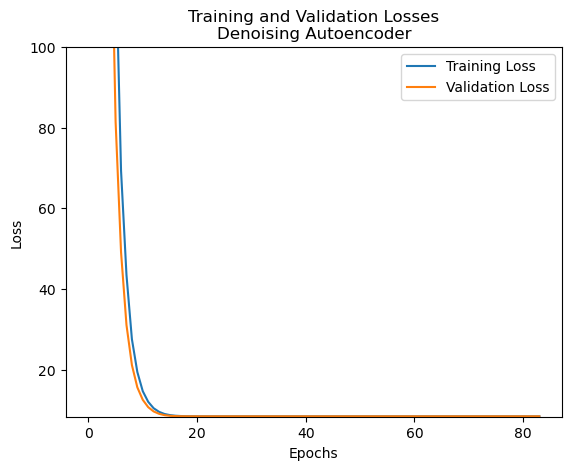

In [118]:
autoencoder_noisy,\
encoder_noisy, decoder_noisy,\
history_noisy = fit_denoising_autoencoder(autoencoder_func=create_autoencoder,
                                          x_train=des_noisy_train, y_train=des_pure_train,
                                          x_val=des_noisy_val, y_val=des_pure_val,
                                          input_dim=des_pure_train.shape[1], latent_dim=2,
                                          patience=50, epochs=1_000, batch_size=128, alpha=1, m=runs, n=sum(n_x), J_cb=J_cb, max_layers=10)
plot_history(history_noisy, title="Denoising Autoencoder", threshold=100)

In [103]:
np.min(history_noisy.history['val_loss'])

8.438385009765625

Epoch 1/1000
10/10 [==============================] - 2s 28ms/step - loss: 312601.2188 - val_loss: 8661.9785
Epoch 2/1000
10/10 [==============================] - 0s 6ms/step - loss: 5342.5840 - val_loss: 2382.8579
Epoch 3/1000
10/10 [==============================] - 0s 6ms/step - loss: 1672.9945 - val_loss: 798.7081
Epoch 4/1000
10/10 [==============================] - 0s 6ms/step - loss: 607.8020 - val_loss: 328.0597
Epoch 5/1000
10/10 [==============================] - 0s 6ms/step - loss: 259.6378 - val_loss: 140.4632
Epoch 6/1000
10/10 [==============================] - 0s 6ms/step - loss: 117.6296 - val_loss: 71.1523
Epoch 7/1000
10/10 [==============================] - 0s 6ms/step - loss: 62.5216 - val_loss: 37.7157
Epoch 8/1000
10/10 [==============================] - 0s 6ms/step - loss: 35.8032 - val_loss: 22.7980
Epoch 9/1000
10/10 [==============================] - 0s 5ms/step - loss: 22.1764 - val_loss: 15.7834
Epoch 10/1000
10/10 [==============================] - 0s 5ms/s

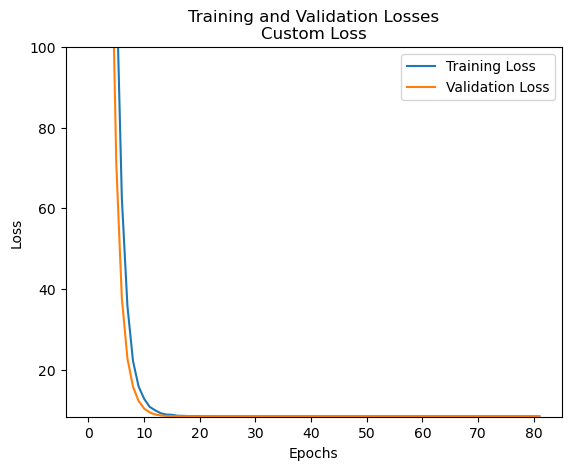

In [119]:
autoencoder, encoder, decoder, history = fit_autoencoder_custom(create_autoencoder,
                                                         train_data=des_pure_train, val_data=des_pure_val,
                                                         input_dim=des_pure_train.shape[1], latent_dim=4, patience=50, epochs=1_000, batch_size=128,
                                                         alpha=1, m=runs, n=sum(n_x), J_cb=J_cb, noise=0, max_layers=10)
plot_history(history, title="Custom Loss", threshold=100)

In [120]:
np.min(history.history['val_loss'])

8.424739837646484

In [18]:
autoencoder_plot, _, _ = create_autoencoder(input_dim=des_pure_train.shape[1], latent_dim=2, max_layers=1)
autoencoder_plot.save('autoencoder.h5')
plot_model(autoencoder_plot, show_shapes=True, show_layer_names=True)

## Distributions

In [22]:
cordex_pure_train, _, _, _ = create_train_val_set(runs=runs,
                                         n_x=n_x,
                                         scalars=scalars,
                                         optimality=optimality,
                                         J_cb=J_cb,
                                         num_designs=1000,
                                         test_size=0.2,
                                         noise=0.1)

100%|██████████| 1000/1000 [03:34<00:00,  4.66it/s]


In [23]:
# Replace the arguments below with your actual parameters
m = runs
n = sum(n_x)
noise = 0

# Calculate the objective function values for each dataset
objective_pure_cordex = [objective_function(design, m, n, J_cb, noise) for design in cordex_pure_train]

output_designs = autoencoder.predict(cordex_pure_train)
objective_output_designs = [objective_function(design, m, n, J_cb, noise) for design in output_designs]

25/25 [==============================] - 0s 2ms/step


In [24]:
# Calculate descriptive statistics for the new designs
mean_new_designs = np.mean(objective_pure_cordex)
std_new_designs = np.std(objective_pure_cordex)
min_new_designs = np.min(objective_pure_cordex)
max_new_designs = np.max(objective_pure_cordex)

# Calculate descriptive statistics for the output designs
mean_output_designs = np.mean(objective_output_designs)
std_output_designs = np.std(objective_output_designs)
min_output_designs = np.min(objective_output_designs)
max_output_designs = np.max(objective_output_designs)

# Create the table data
table_data = [
    ["Mean", mean_new_designs, mean_output_designs],
    ["Standard Deviation", std_new_designs, std_output_designs],
    ["Min", min_new_designs, min_output_designs],
    ["Max", max_new_designs, max_output_designs]
]

# Print the table with a header
print(tabulate(table_data, headers=["", "Cordex Designs", "Output Designs"], floatfmt=".3f", tablefmt="orgtbl"))

|                    |   Cordex Designs |   Output Designs |
|--------------------+------------------+------------------|
| Mean               |          112.490 |           64.040 |
| Standard Deviation |           24.532 |            0.000 |
| Min                |           78.589 |           64.040 |
| Max                |          246.707 |           64.040 |


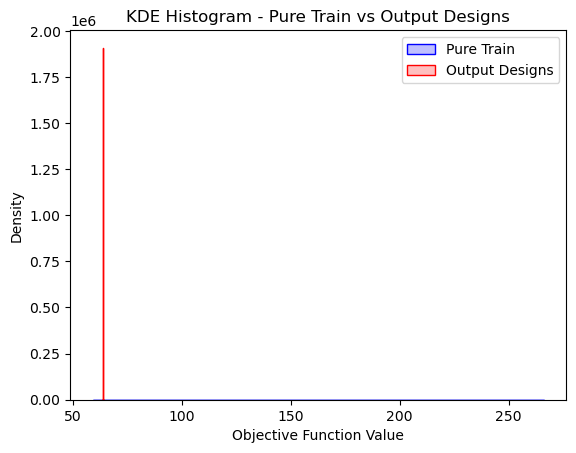

In [25]:
# Plot KDE histograms
sns.kdeplot(objective_pure_cordex, fill=True, color='blue', label='Pure Train')
sns.kdeplot(objective_output_designs, fill=True, color='red', label='Output Designs')
plt.legend()
plt.xlabel('Objective Function Value')
plt.ylabel('Density')
# plt.ylim(0,0.1)
plt.title('KDE Histogram - Pure Train vs Output Designs')
plt.show()

In [ ]:
 # Latent BO
# results = latent_auto_bo(runs=runs,
#                          n_x=n_x,
#                          J_cb=J_cb,
#                          decoder=decoder,
#                          latent_dim=8,
#                          n_iterations=70,
#                          n_runs=3,
#                          initial_point_generator='random',
#                          acq_func='EI')
# plot_convergence(results, "Convergence for multiple random starts", threshold=10)
# optimal_mat, optimal_cr, gp_results = results[np.argmin([result[1] for result in results])]
# plot_obj(gp_result)
# plot_evals(gp_result)
# subplot_results(sub_x=2, sub_y=2, T=np.linspace(0,1,100), results=optimal_mat)
# objective_function(optimal_mat,m=runs, n=sum(n_x), J_cb=J_cb, noise=0)

In [ ]:
# cordex_mat, cordex_opt = cordex_discrete(runs=runs,
#                                          f_list=n_x,
#                                          scalars=scalars,
#                                          levels=[-1,0,1],
#                                          epochs=5,
#                                          optimality=optimality,
#                                          J_cb=J_cb)
# cordex_mat, cordex_opt = cordex_discrete(runs=runs,
#                                          f_list=n_x,
#                                          scalars=scalars,
#                                          levels=[-1,1],
#                                          epochs=1,
#                                          optimality=optimality,
#                                          J_cb=J_cb)
#
# subplot_results(sub_x=2, sub_y=2, T=np.linspace(0,1,100), results=cordex_mat)
# print(cordex_opt)

In [121]:
if np.min(history_noisy.history['val_loss']) < np.min(history.history['val_loss']):
    use_denoising = True
    use_normal = False
else:
    use_denoising = False
    use_normal = True

results, all_designs = optimize_designs(encoder, decoder, encoder_noisy, decoder_noisy, cordex_discrete, objective_function, runs, n_x, scalars, optimality, J_cb, n_repetitions=5, n_iterations=3, use_denoising=use_denoising, use_normal=use_normal)

100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


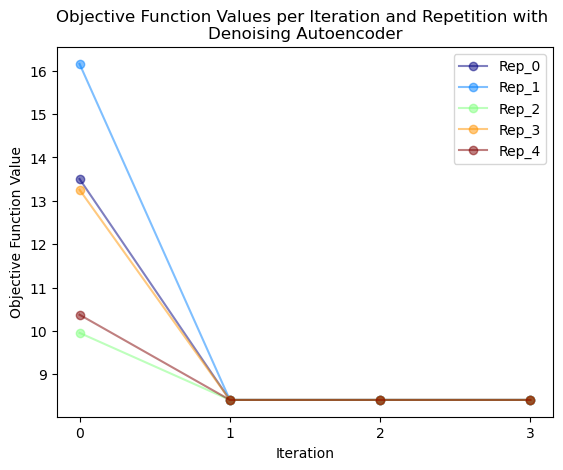

In [122]:
plot_results(results, n_repetitions=5)

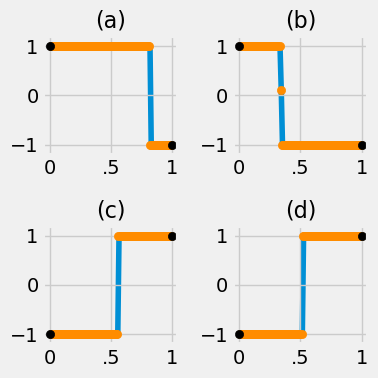

Best Design Optimality Criterion: 8.406


In [123]:
best_opt, best_des = find_best_design(results, all_designs)
subplot_results(sub_x=2, sub_y=2, T=np.linspace(0,1,100), results=best_des)
print(f"Best Design Optimality Criterion: {np.round(best_opt,3)}")

In [ ]:
# X = np.linspace(-1,1,1000)
# y = []
# for x in X:
#     xi = np.reshape(x, (1, -1))
#     decoded_output = decoder_noiseless.predict(xi)
#     y.append(objective_function(decoded_output,m=runs, n=sum(n_x), J_cb=J_cb, noise=0))

In [ ]:
# from matplotlib import pyplot as plt
# plt.style.use('default')
# plt.plot(X,y)
# plt.ylim(0,20)
# plt.show()

## Latent space Representation

In [44]:
def plot_latent_space(train_data, val_data, opt_des, n_components, threshold=10):

    train_data = np.append(train_data, opt_des.reshape(1,-1), axis=0)
    latent_train = encoder.predict(train_data)
    latent_val = encoder.predict(val_data)
    obj_train = [objective_function(d, runs, sum(n_x), J_cb=Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(n_x, n_b)]), noise=0) for d in des_pure_train]
    obj_val = [objective_function(d, runs, sum(n_x), J_cb=Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(n_x, n_b)]), noise=0) for d in des_pure_val]

    obj_opt = objective_function(opt_des, runs, sum(n_x), J_cb=Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(n_x, n_b)]), noise=0)
    obj_combined = obj_train + obj_val + [obj_opt]

    combined_data = np.vstack((latent_train, latent_val))

    # Filter out the designs with objective values higher than the threshold
    filtered_indices = [i for i, obj in enumerate(obj_combined) if obj <= threshold]
    filtered_obj_combined = [obj_combined[i] for i in filtered_indices]
    filtered_combined_data = combined_data[filtered_indices]

    min_val, max_val = np.round(np.max(filtered_obj_combined), 2), np.round(np.min(filtered_obj_combined), 2)
    colors_filtered = (np.array(filtered_obj_combined[:-1]) - min_val) / (max_val - min_val)

    pca = PCA(n_components=n_components)
    filtered_combined_data_pca = pca.fit_transform(filtered_combined_data)

    if n_components == 2:
        plt.figure(figsize=(10, 6))
        plt.scatter(filtered_combined_data_pca[:-1, 0], filtered_combined_data_pca[:-1, 1], c=colors_filtered, marker='o', alpha=0.6)
        plt.scatter(filtered_combined_data_pca[-1, 0], filtered_combined_data_pca[-1, 1], c='red', marker='*', s=200, label='Optimum Design')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.title('Latent Space Visualization using PCA (2D)')
    elif n_components == 3:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(filtered_combined_data_pca[:-1, 0], filtered_combined_data_pca[:-1, 1], filtered_combined_data_pca[:-1, 2], c=colors_filtered, marker='o', alpha=0.6)
        ax.scatter(filtered_combined_data_pca[-1, 0], filtered_combined_data_pca[-1, 1], filtered_combined_data_pca[-1, 2], c='red', marker='*', s=200, label='Optimum Design')
        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')
        ax.set_zlabel('Principal Component 3')
        ax.set_title('Latent Space Visualization using PCA (3D)')

    if n_components == 2:
        scatter_plot = plt.scatter(filtered_combined_data_pca[:-1, 0], filtered_combined_data_pca[:-1, 1], c=colors_filtered, marker='o', alpha=0.6)
        scatter_plot = plt.scatter(filtered_combined_data_pca[-1, 0], filtered_combined_data_pca[-1, 1], c='red', marker='*', s=200, label='Optimum Design')
    elif n_components == 3:
        scatter_plot = ax.scatter(filtered_combined_data_pca[:-1, 0], filtered_combined_data_pca[:-1, 1], filtered_combined_data_pca[:-1, 2], c=colors_filtered, marker='o', alpha=0.6)
        scatter_plot = ax.scatter(filtered_combined_data_pca[-1, 0], filtered_combined_data_pca[-1, 1], filtered_combined_data_pca[-1, 2], c='red', marker='*', s=200, label='Optimum Design')

    cbar = plt.colorbar(scatter_plot)
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels([min_val, max_val])
    cbar.set_label('Objective function value')

    plt.show()

In [45]:
plot_latent_space(train_data=des_pure_train, val_data=des_pure_val, opt_des=best_des, n_components=2, threshold=20)

10/10 [==============================] - 0s 2ms/step


ValueError: zero-size array to reduction operation maximum which has no identity

In [46]:
def filter_by_threshold(train_data, val_data, opt_des, threshold):
    obj_train = [objective_function(d, runs, sum(n_x), J_cb=Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(n_x, n_b)]), noise=0) for d in des_pure_train]
    obj_val = [objective_function(d, runs, sum(n_x), J_cb=Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(n_x, n_b)]), noise=0) for d in des_pure_val]

    # Add the objective function value of the optimized design to the combined list
    obj_opt = objective_function(opt_des, runs, sum(n_x), J_cb=Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(n_x, n_b)]), noise=0)
    obj_combined = obj_train + obj_val + [obj_opt]

    # Combine the train and validation data
    combined_data = np.vstack((train_data, val_data))

    # Add the optimized design to the combined data
    combined_data = np.append(combined_data, opt_des.reshape(1,-1), axis=0)

    # Filter designs based on the threshold value
    indices_below_threshold = [i for i, obj_value in enumerate(obj_combined) if obj_value <= threshold]
    obj_combined_filtered = [obj_combined[i] for i in indices_below_threshold]
    combined_data_filtered = combined_data[indices_below_threshold]

    return obj_combined_filtered, combined_data_filtered
def plot_latent_space_tsne(train_data, val_data, opt_des, threshold=10):

    # Filter the designs based on the threshold value
    obj_combined_filtered, combined_data_filtered = filter_by_threshold(train_data, val_data, opt_des, threshold)

    # Encode the filtered train and validation data to the latent space
    latent_train_filtered = encoder.predict(combined_data_filtered[:-1])
    latent_val_filtered = encoder.predict(combined_data_filtered[-1:])

    # Normalize the objective function values for color-coding
    min_val, max_val = np.round(np.max(obj_combined_filtered), 2), np.round(np.min(obj_combined_filtered), 2)
    colors_filtered = (np.array(obj_combined_filtered[:-1]) - min_val) / (max_val - min_val)

    # Combine the filtered train and validation data
    combined_data_latent_filtered = np.vstack((latent_train_filtered, latent_val_filtered))

    # Apply t-SNE to the combined data
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    combined_data_tsne = tsne.fit_transform(combined_data_latent_filtered)

    # Plot the reduced latent space in 2D
    plt.figure(figsize=(10, 6))
    plt.scatter(combined_data_tsne[:-1, 0], combined_data_tsne[:-1, 1], c=colors_filtered, marker='o', alpha=0.6)
    plt.scatter(combined_data_tsne[-1, 0], combined_data_tsne[-1, 1], c='red', marker='*', s=200, label='Optimum Design')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title('Latent Space Visualization using t-SNE (2D)')

    # Add colorbar to show the objective function values
    scatter_plot = plt.scatter(combined_data_tsne[:-1, 0], combined_data_tsne[:-1, 1], c=colors_filtered, marker='o', alpha=0.6)
    scatter_plot = plt.scatter(combined_data_tsne[-1, 0], combined_data_tsne[-1, 1], c='red', marker='*', s=200, label='Optimum Design')

    cbar = plt.colorbar(scatter_plot)
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels([min_val, max_val])
    cbar.set_label('Objective function value')

    plt.show()

In [47]:
plot_latent_space_tsne(train_data=des_pure_train, val_data=des_pure_val, opt_des=best_des, threshold=20)

ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

## 3d-Plot of the latent space

In [48]:
# Create a grid of points in the 2D latent space
x = np.linspace(-1, 1, 1_000)
y = np.linspace(-1, 1, 1_000)
x_grid, y_grid = np.meshgrid(x, y)
latent_points = np.vstack([x_grid.ravel(), y_grid.ravel()]).T

# Use the decoder to transform the points back to the original space
decoded_points = decoder.predict(latent_points)

# Calculate the objective function values for each point
z_values = np.array([objective_function(point, m=runs, n=sum(n_x), J_cb=J_cb, noise=0) for point in decoded_points])

# Reshape the z_values to match the grid shape
z_grid = z_values.reshape(x_grid.shape)

# Find the index of the minimum value in z_values
min_index = np.argmin(z_values)

# Find the corresponding point in the latent space and the original space
min_latent_point = latent_points[min_index]
min_decoded_point = decoded_points[min_index]
min_z_value = z_values[min_index]

# Create the interactive 3D surface plot with the marked minimum
fig = go.Figure(data=[
    go.Surface(x=x_grid, y=y_grid, z=z_grid, colorscale='Viridis', reversescale=True),
    go.Scatter3d(x=[min_latent_point[0]], y=[min_latent_point[1]], z=[min_z_value],
                 mode='markers', marker=dict(size=8, color='red', symbol='circle'))
])

fig.update_layout(scene=dict(xaxis_title='Latent Dimension 1',
                             yaxis_title='Latent Dimension 2',
                             zaxis_title='Objective Function Value'),
                  title='Interactive 3D Surface Plot with Minimum')

# Save the interactive plot to an HTML file
pio.write_html(fig, file='interactive_3d_with_minimum.html', auto_open=True)

31250/31250 [==============================] - 30s 947us/step
